# We are trying to colour the histogram for cutoffs:

If you're looking at this and want the useful things to copy just skip to step 2 and check out the edits to the histogram plot stuff!

## Step 1: copy a bunch of code so that things run haha

In [5]:
#Since I can't figure out how to import network_utilities, I'll just dump Elden's code here.

#===============================================================================================================================#
# This .py contains some of the standard utility functions that would be frustrating to intersperse in the Jupyter notebooks.   #
# Rather, they are included here, and should be imported in with "import network_utilities as nu"                               #
#===============================================================================================================================#

import networkx as nx

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# let's define a little function to trim the leading "4932." off protein names
# This _should_ work with any hierarchy of strings in lists.
def trim(protein_name):
    if (type(protein_name) is str):   
        # returns everything _after_ the first period.
        return '.'.join(protein_name.split(".")[1:])
    elif (type(protein_name) is list):
        trimmed_list = []
        for name in protein_name:
            trimmed_list.append(trim(name))
        return trimmed_list

# A simple QoL function to cut down a network to a given nodelist (as opposed to the converse, which nx supplies)
def cutdown_network(graph, nodelist):
    graph_copy = graph.copy(); # just to allow modification
    nodes_to_remove = set(graph.nodes) - set(nodelist);
    graph_copy.remove_nodes_from(nodes_to_remove)
    return graph_copy

# My custom drawing function, with all my prefered defaults set. 
def my_draw(graph, # The networkx network to be plotted
            kkl=False, # whether to use Kamada Kawai algorithm for layout. Looks nice, but is (much) slower
            color_by_weight=True, # Edge colors by confidence weight. 
                                  # ...Most of the nice things here assume this is True. Turn off at your peril... plus it looks pretty :P
            node_color="Blue", # Either a single string "Blue", "b", "r", or a list of the colors of individual node colors in order
            node_size=10, # Similar to above
            alpha=0.8, # The _node_ opacity. Similar to above (single value or list). Note that this will be modulated
            key_text=None, # Text at the bottom of the figure
            title_text=None, # Text above figure
            
            with_labels=False, # whether to include node labels. Can get very messy.
            labels=None, # if with_labels is true, and this an array, then these labels are printed instead.
            font_size=10,
            
            delay_show=False): # whether to not run plt.show() at end. Use this if you want to include more matplotlib details,
                               # or with to run nu.draw_path_from_nodes(...) - see below 
    # "make a new figure"
    network_fig = plt.figure(figsize=(12,12))
    # Pick the layout option. At the moment I just have KK or spring. KK is much more time-intensive.
    if (kkl):
        my_layout = nx.kamada_kawai_layout(graph, weight=None);
    else:
        my_layout = nx.spring_layout(graph, k=0.5);
    # We will almost always want to color by weight... if only 'cause it is prettier!
    if (color_by_weight):
        edges = graph.edges()
        weights = [graph[u][v]['weight'] for u,v in edges]
        # Pick the colormap here if you like!
        cmap=plt.cm.plasma;
        # TODO 
        these_labels = None;
        if (with_labels and labels is None):
                        node_names = list(graph.nodes);
                        these_labels = {l : l for l in node_names} # note that we need to pass a dict not a list
                        nx.draw_networkx_labels(graph, my_layout, labels=these_labels, font_size=font_size)
        elif (with_labels and labels is not None):
            node_names = list(graph.nodes);
            dict_labels = {node_names[l] : labels[l] for l in range(len(node_names))}
            nx.draw_networkx_labels(graph, my_layout, labels=dict_labels, font_size=font_size)
            
        nx.draw_networkx_nodes(graph, pos=my_layout, node_size=node_size, alpha=alpha, node_color=node_color)
        nx.draw_networkx_edges(graph, pos=my_layout, edge_color=weights, edge_cmap=cmap, width=0.2)

        # Adding a colorbar as per https://stackoverflow.com/questions/26739248/how-to-add-a-simple-colorbar-to-a-network-graph-plot-in-python
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = min(weights), vmax=max(weights)))
        sm._A = [];
        cb = plt.colorbar(sm, aspect=50, fraction=0.05);
        cb.set_label("Confidence score", fontsize=15);
    else:
        # If not coloring by weight... (I really haven't worked to make this that nice though!)
        nx.draw(graph, pos=my_layout, node_size=node_size, alpha=alpha, node_color=node_color, font_size='10',with_labels=False)
    # Title, and text in bottom left
    if (key_text is not None):
        network_fig.text(0.15,0.15, key_text, fontsize=15, fontweight='light')
    if (title_text is not None):
        plt.title(title_text);
    # "show the figure"
    if (delay_show is False): plt.show();
    return my_layout;

In [6]:
#Credit to Elden Loomes for creating the code below. Now if I could just figure out how to import network_utilities...

"""Imports and arguments"""

import csv

#import networkx as nx

#import numpy as np
#import scipy as sp
#import matplotlib.pyplot as plt
#import network_utilities as nu
import random
import networkx.algorithms.community as nx_comm

# some basic settings for plotting figures
%matplotlib inline 
font = {'family' : 'serif',
        'weight' : 'light',
        'size'   : 20}

plt.rc('font', **font)

# THE PROTEIN OF INTEREST ================================#
this_protein = 'YNL267W';                                 #
# ========================================================#

long_outputs = True;

## Step 2: look at the actual histogram code and edit this!

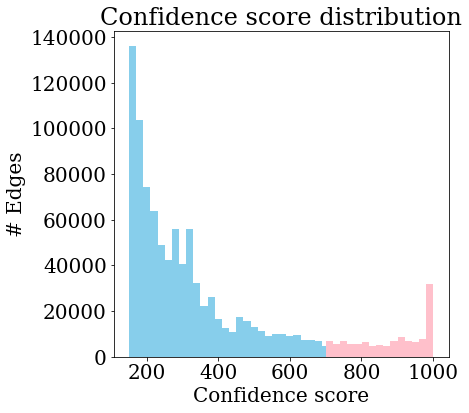

In [37]:
"""Loading Data"""

# This is the variable that will store the protein names. 
ess_list = [];

with open("essential_proteins.csv", newline='') as ess_file:
    reader = csv.reader(ess_file)
    ess_data = list(reader)

for i in range(len(ess_data)):
    ess_list.append(ess_data[i][1])
    
# Read in the string-db for Yeast
G0 = nx.read_weighted_edgelist("yeast_protein_edgelist_trimmed.txt",comments="#",nodetype=str)
threshold_score = 700; #we need the threshold score earlier so we can colour confidence!

# For interest, plot the distribution of confidence scores
if (long_outputs):
    plt.figure(figsize=(6,6));
    full_edges = G0.edges()
    these_weights = [G0[u][v]['weight'] for u,v in full_edges]
    these_weights_ar = np.array(these_weights)
    these_weights_under = these_weights_ar[these_weights_ar<=threshold_score]
    these_weights_over = these_weights_ar[these_weights_ar>threshold_score]
    binwidth = 20 #this is what to change if you want more or less bins! 
    min_under = int(min(these_weights_under))
    max_under=int(max(these_weights_under))
    min_over = int(min(these_weights_over))
    max_over= int(max(these_weights_over))
    plt.hist(these_weights_under, bins=range(min_under, max_under + binwidth, binwidth),color="skyblue")
    plt.hist(these_weights_over,bins=range(min_over, max_over + binwidth, binwidth),color="pink")
    plt.title("Confidence score distribution")
    plt.xlabel("Confidence score")
    plt.ylabel("# Edges")
    plt.show();
    
# delete those edges with a combined score of <= threshold_score (small confidence)

for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])
        
# Take only the largest connected subgraph
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc);
print(G)

## Code working below - can ignore this, was just me figuring out how to work with it

In [8]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt")

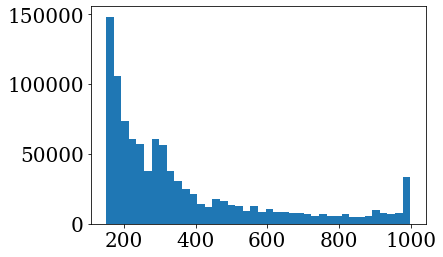

In [10]:
full_edges = G0.edges()
these_weights = [G0[u][v]['weight'] for u,v in full_edges]
plt.hist(these_weights, bins=40);

In [18]:
these_weights_ar = np.array(these_weights)

In [19]:
these_weights_ar

array([347., 945., 163., ..., 173., 950., 920.])

In [20]:

these_weights_under = these_weights_ar[these_weights_ar<=700]
these_weights_over = these_weights_ar[these_weights_ar>700]

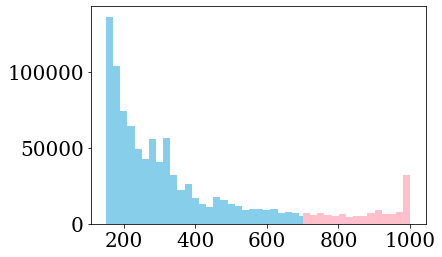

In [35]:
binwidth = 20
min_under = int(min(these_weights_under))
max_under=int(max(these_weights_under))
min_over = int(min(these_weights_over))
max_over= int(max(these_weights_over))

plt.hist(these_weights_under, bins=range(min_under, max_under + binwidth, binwidth),color="skyblue")
plt.hist(these_weights_over,bins=range(min_over, max_over + binwidth, binwidth),color="pink")
plt.show()

In [26]:
int(max(these_weights_under))

700

In [32]:
min_over

701